In [2]:
# Here in this section, we have imported all the necessary packages to compile the model
from keras import layers
from keras import regularizers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
import pandas as pd
import os
import cv2
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\adarabi3\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [3]:
training_data=[]
datadir="C:/Users/adarabi3/OneDrive - Georgia Institute of Technology/Documents/MATLAB/Lens_data/Image_output/"
path = os.path.join(datadir)
image_list = os.listdir(path)
# we import a list of all the images as the input function
for img in image_list:
    image_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    image_array2=cv2.resize(image_array,(100,100))
    # plt.imshow(image_array,cmap="gray")
    # plt.show()
    # break
    training_data.append([image_array2])

In [4]:
# the output for all the generated data are stored in a csv file
X=[]
for features in training_data:
    X.append(features)    
X=np.array(X).reshape(-1,100,100,1)
Y_train = pd.read_csv("Data_param.csv")
Y= Y_train.to_numpy().reshape(-1,11)
print(Y.shape)
print(X.shape)

(21000, 11)
(21000, 100, 100, 1)


In [5]:
x_train=X[0:20000]
x_test=X[20000:21001]
y_train=Y[0:20000]
y_test=Y[20000:21001]
x_train=x_train/255
x_test=x_test/255
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 100, 100, 1)
(1000, 100, 100, 1)
(200, 11)
(1000, 11)


In [6]:
def identity_block(X, f, filters, stage, block):
    """
    X -> is the image/tensor of shape (m, H, W, C)
    f -- the kernal size for the internal COnv2d layers
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # laoding filters from the function
    F1, F2, F3 = filters
    
    # the X_shortcut is the feedback which will be added to the convoluted data, at the end of the block
    X_shortcut = X
    
    # First step
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second step
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third step
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Fourth step: Add shortcut value to main path, and later pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [7]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    X -> is the image/tensor of shape (m, H, W, C)
    f -- the kernal size for the internal COnv2d layers
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters from the function
    F1, F2, F3 = filters
    
    # the X_shortcut is the feedback which will be added to the convoluted data, at the end of the block
    X_shortcut = X


    # First part 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    # Second part
    X = Conv2D(F2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third path 
    X = Conv2D(F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # The path for the feedback path 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 
    
    
    return X

In [8]:
def ResNet(input_shape = (400, 400, 1), classes = 10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK*5 -> Dense Layer

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of elements in the putput

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (2, 2), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
 
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [16, 16, 32], stage = 2, block='a', s = 1)
 

    # Stage 3
    X = convolutional_block(X, f=3, filters=[32, 32, 64], stage=3, block='a', s=2)
 
    # Stage 4
    X = convolutional_block(X, f=3, filters=[64, 64, 128], stage=4, block='a', s=2)
 
    # Stage 5
    X = convolutional_block(X, f=3, filters=[128, 128, 256], stage=5, block='a', s=2)
 
    # Stage 6
    X = convolutional_block(X, f=3, filters=[256, 256, 512], stage=6, block='a', s=2)
 
 
    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)#,kernel_regularizer=tf.keras.regularizers.l1(0.1))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

In [9]:
model = ResNet(input_shape = (100, 100, 1), classes = 11)

In [11]:
# model.compile(optimizer='ADAM', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics=['accuracy'])
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 53, 53, 64)   320         ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 53, 53, 64)   256         ['conv1[0][0]']           

In [ ]:
rediction=model.fit(x_train,y_train,epochs=500,batch_size=32)

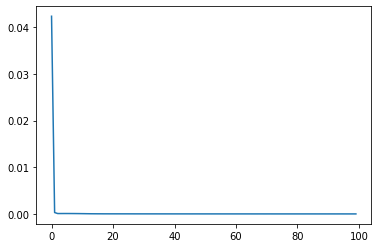

In [105]:
plt.plot(rediction.history["loss"])

In [14]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

32/32 [==============================] - 1s 34ms/step - loss: 3.6038e-05 - accuracy: 0.5240
Loss = 3.603815639507957e-05
Test Accuracy = 0.5239999890327454


In [ ]:
Y_data=x_train[10]
Y_data=Y_data.reshape(1,100,100,-1)
print(Y_data.shape)
q=model.predict(Y_data)
print(q)
print(y_train[10])
mse = tf.keras.losses.MeanAbsoluteError()
error=mse(q, y_train[10]).numpy()
print(error)
# print(q-y_train[100])